In [7]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure
import seaborn as sns
from pathlib import Path
import logging
from tqdm import tqdm
from scipy import stats

# Basic configurations
Image.MAX_IMAGE_PIXELS = None  # Remove image size limit
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')

# Set font for plotting
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    

def pixel_to_area(pixels, resolution=3.0):
    """
    Convert pixel count to actual area (square meters)
    
    Args:
        pixels: number of pixels
        resolution: resolution (meters/pixel)
    """
    return pixels * (resolution ** 2)

def analyze_building_sizes(building_mask, resolution=3.0):
    """
    Analyze building size distribution, handling outliers
    
    Args:
        building_mask: binary building mask image
        resolution: image resolution (meters/pixel)
    """
    # Connected component analysis
    print("Performing connected component analysis...")
    building_labels = measure.label(building_mask)
    num_buildings = building_labels.max()
    print(f"Detected building count: {num_buildings}")
    
    # Collect building sizes
    print("\nCalculating building sizes...")
    sizes = []
    for building_id in tqdm(range(1, num_buildings + 1), desc="Processing buildings"):
        building_mask = building_labels == building_id
        size = np.sum(building_mask)
        sizes.append(size)
    
    sizes = np.array(sizes)
    areas = np.array([pixel_to_area(s, resolution) for s in sizes])
    
    # Calculate outlier boundaries
    Q1 = np.percentile(sizes, 25)
    Q3 = np.percentile(sizes, 75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    
    # Separate normal values and outliers
    normal_sizes = sizes[sizes <= upper_bound]
    outlier_sizes = sizes[sizes > upper_bound]
    normal_areas = areas[sizes <= upper_bound]
    outlier_areas = areas[sizes > upper_bound]
    
    # Create outlier mask
    print("\nProcessing outlier buildings...")
    outlier_buildings = np.zeros_like(building_mask, dtype=bool)
    normal_buildings = np.zeros_like(building_mask, dtype=bool)
    
    for building_id in tqdm(range(1, num_buildings + 1), desc="Identifying outliers"):
        current_mask = building_labels == building_id
        size = np.sum(current_mask)
        if size > upper_bound:
            outlier_buildings |= current_mask
        else:
            normal_buildings |= current_mask
    
    print("\nStatistics:")
    print(f"Total number of buildings: {len(sizes)}")
    print(f"Number of normal buildings: {len(normal_sizes)}")
    print(f"Number of outliers: {len(outlier_sizes)}")
    
    # Create multi-subplot visualization
    plt.figure(figsize=(15, 15))
    
    # 1. Original distribution (with outlier marking)
    plt.subplot(3, 1, 1)
    sns.histplot(data=areas, bins=50, color='blue', alpha=0.5, label='All Buildings')
    plt.axvline(pixel_to_area(upper_bound, resolution), color='red', linestyle='--', 
                label='Outlier Threshold')
    plt.title('Complete Building Size Distribution')
    plt.xlabel('Area (m²)')
    plt.ylabel('Count')
    plt.legend()
    
    # 2. Normal value distribution (outliers removed)
    plt.subplot(3, 1, 2)
    sns.histplot(data=normal_areas, bins=50, color='green', alpha=0.5)
    plt.title('Building Size Distribution (Outliers Removed)')
    plt.xlabel('Area (m²)')
    plt.ylabel('Count')
    
    # 3. Logarithmic scale distribution
    plt.subplot(3, 1, 3)
    sns.histplot(data=np.log10(areas), bins=50, color='purple', alpha=0.5)
    plt.title('Building Size Distribution (Logarithmic Scale)')
    plt.xlabel('Log10(Area) (m²)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Box plot visualization
    plt.figure(figsize=(10, 6))
    plt.boxplot(areas, vert=False, whis=1.5)
    plt.title('Building Size Box Plot')
    plt.xlabel('Area (m²)')
    plt.show()
    
    # Statistical summary
    print("\nNormal Value Statistics (After Removing Outliers):")
    print(f"Minimum area: {normal_areas.min():.1f} m²")
    print(f"Maximum area: {normal_areas.max():.1f} m²")
    print(f"Mean area: {normal_areas.mean():.1f} m²")
    print(f"Median area: {np.median(normal_areas):.1f} m²")
    
    # Display outlier building map
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(normal_buildings, cmap='viridis')
    plt.title('Normal Buildings')
    plt.colorbar()
    
    plt.subplot(122)
    plt.imshow(outlier_buildings, cmap='viridis')
    plt.title('Outlier Buildings')
    plt.colorbar()
    plt.show()
    
    # Spatial distribution plot (using logarithmic scale)
    plt.figure(figsize=(10, 10))
    building_sizes = np.zeros_like(building_labels, dtype=float)
    for building_id in tqdm(range(1, num_buildings + 1), desc="Generating spatial distribution"):
        building_mask = building_labels == building_id
        size = np.sum(building_mask)
        building_sizes[building_mask] = np.log10(size) if size > 0 else 0
    
    plt.imshow(building_sizes, cmap='viridis')
    plt.colorbar(label='Log10(Building Size) (pixels)')
    plt.title('Building Size Spatial Distribution (Logarithmic Scale)')
    plt.show()
    
    return sizes, normal_sizes, outlier_sizes, outlier_buildings, normal_buildings

# Main execution
# Replace with your mask file path
image = Image.open('../images/20210709_073742_79_2431_3B_Visual_clip.tif')
width, height = image.size
building_mask_path = "../buildingmasks/mask_Rubizhne.tif"
print("Starting data loading...")
try:
    # Load mask
    mask = np.array(Image.open(building_mask_path))
    mask = mask.resize((width, height), Image.NEAREST)
    if mask.ndim > 2:
        print("Detected multi-channel image, converting to single channel...")
        mask = mask[:,:,0]  # If multi-channel, take the first channel
    mask = mask > 0  # Binarize
    print("Data loading complete, starting analysis...")
    
    # Analyze building size distribution
    sizes, normal_sizes, outlier_sizes, outlier_buildings, normal_buildings = analyze_building_sizes(mask, resolution=3.0)
    
except Exception as e:
    print(f"Error occurred during analysis: {e}")

Starting data loading...
Error occurred during analysis: 'tuple' object cannot be interpreted as an integer


Starting data loading...
Data loading complete, starting analysis...
Performing connected component analysis...
Detected building count: 6603

Calculating building sizes...


Processing buildings: 100%|██████████| 6603/6603 [00:48<00:00, 135.42it/s]



Outlier Threshold Details:
Q1 (25th percentile): 7.0 pixels (63.0 m²)
Q3 (75th percentile): 22.0 pixels (198.0 m²)
IQR: 15.0 pixels (135.0 m²)
Outlier threshold (Q3 + 1.5*IQR): 44.5 pixels (400.5 m²)

Outlier Statistics:
Smallest outlier: 45.0 pixels (405.0 m²)
Largest outlier: 11271.0 pixels (101439.0 m²)
Mean outlier size: 140.9 pixels (1267.8 m²)

Processing outlier buildings...


Identifying outliers: 100%|██████████| 6603/6603 [00:52<00:00, 125.69it/s]
C:\Users\xiao\AppData\Local\Temp\ipykernel_20524\3058375050.py:128: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()



Statistics:
Total number of buildings: 6603
Number of normal buildings: 5512
Number of outliers: 1091


c:\Users\xiao\anaconda\envs\xbd\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


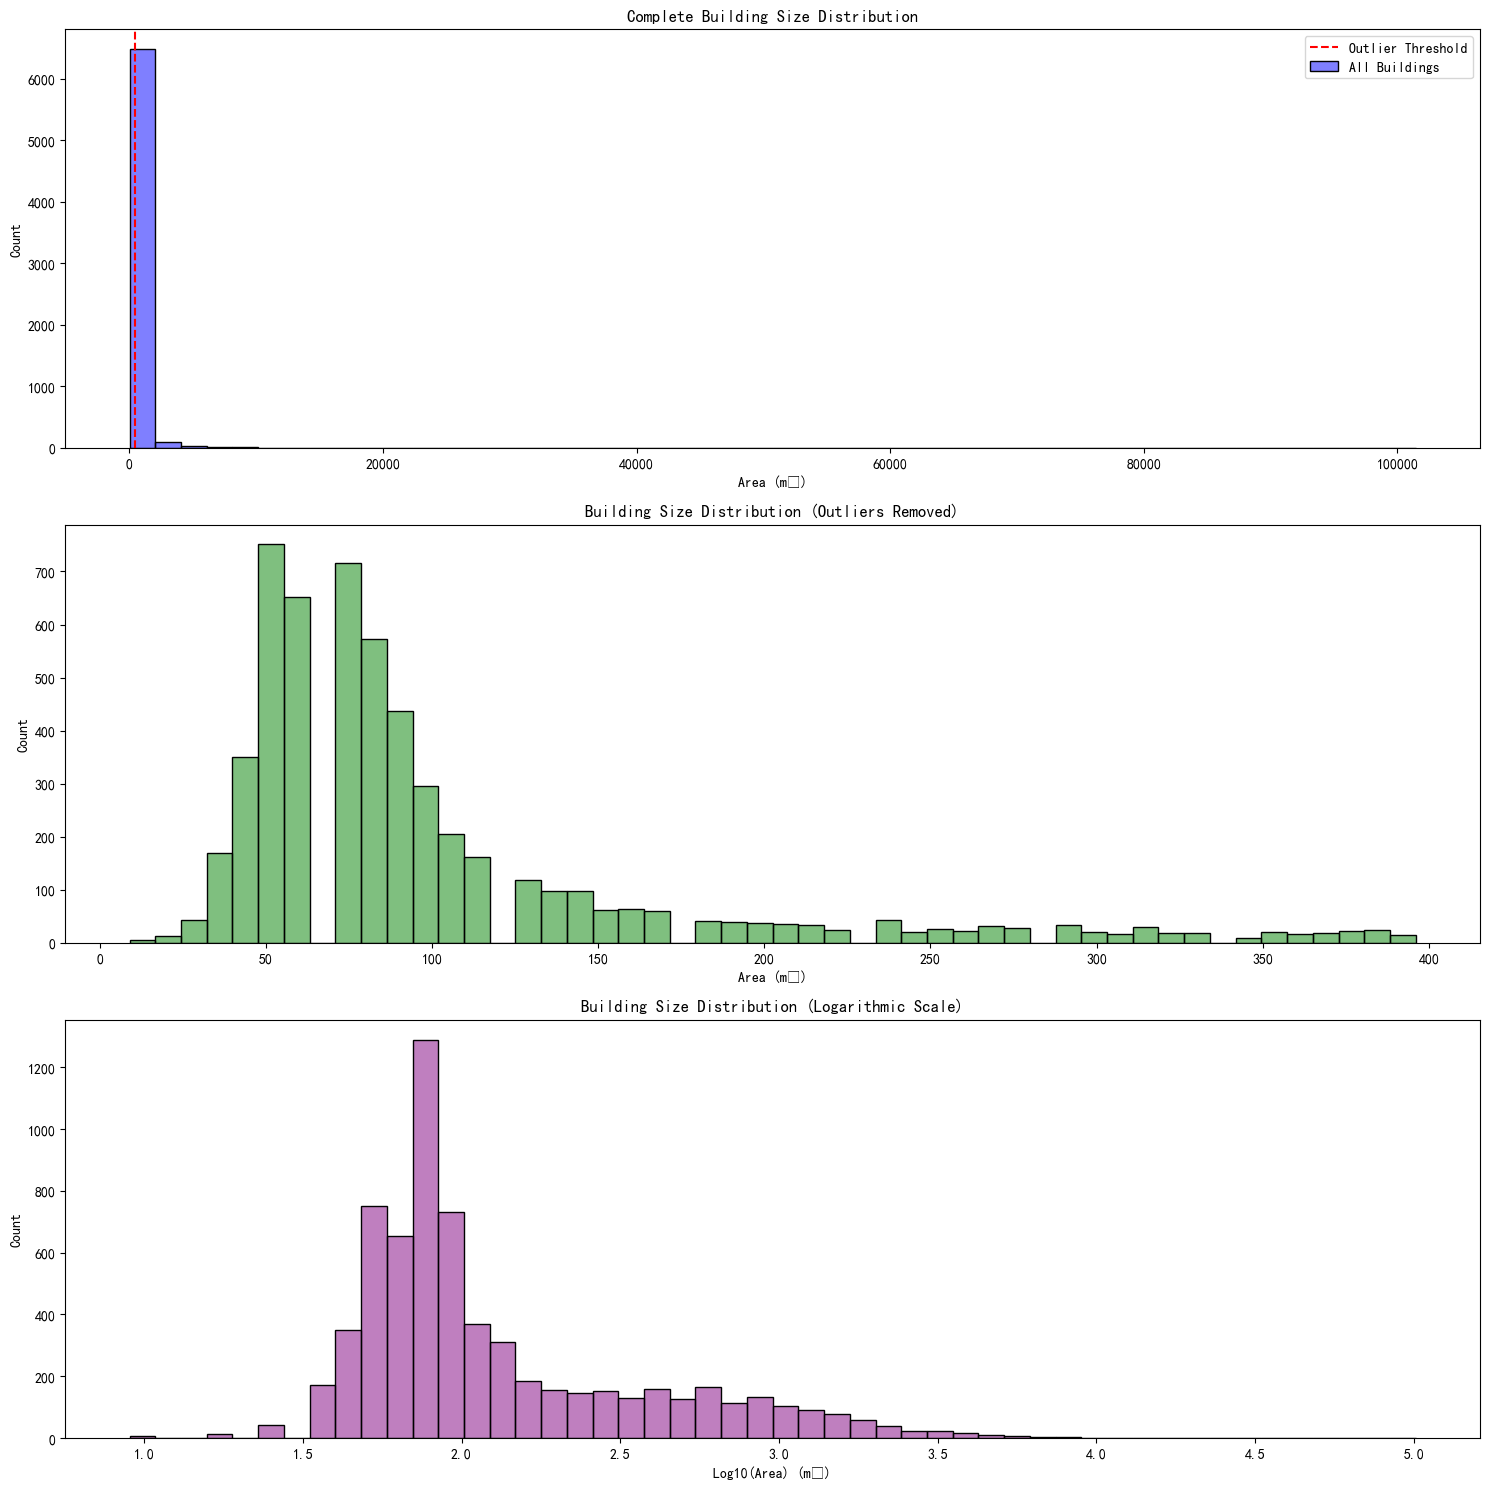

c:\Users\xiao\anaconda\envs\xbd\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


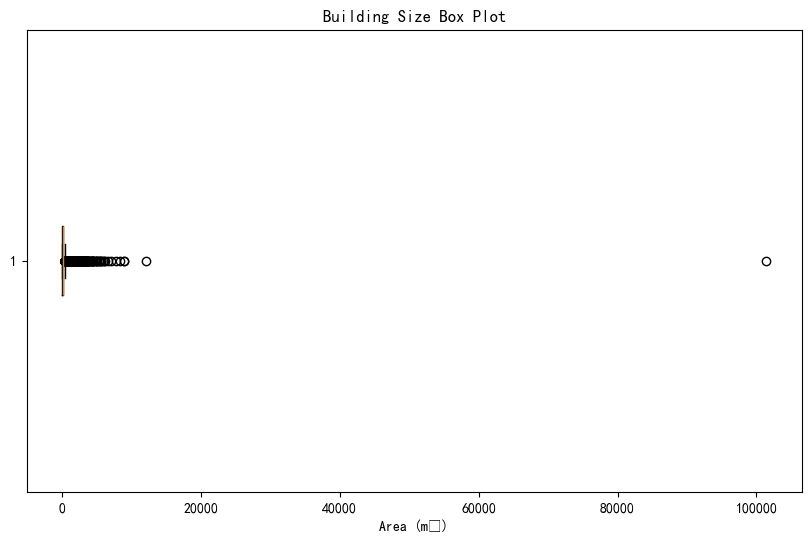


Normal Value Statistics (After Removing Outliers):
Minimum area: 9.0 m²
Maximum area: 396.0 m²
Mean area: 101.4 m²
Median area: 81.0 m²


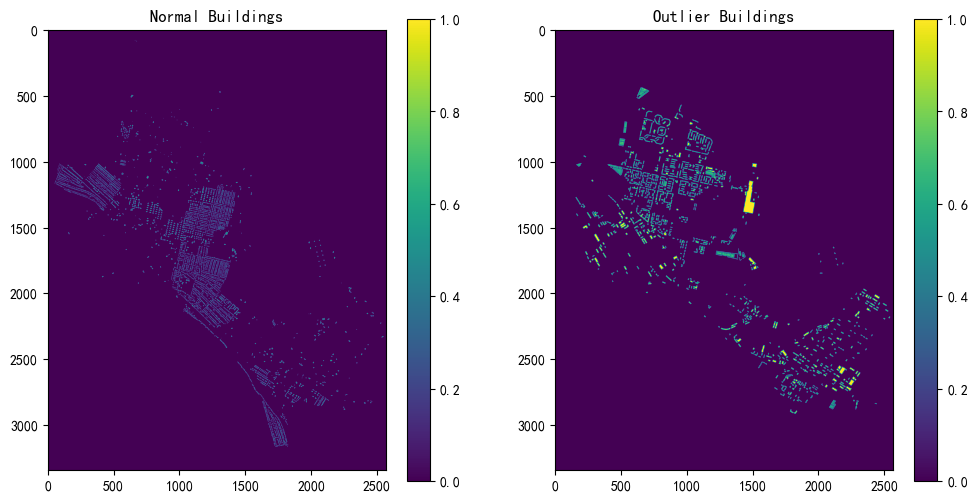

Generating spatial distribution: 100%|██████████| 6603/6603 [00:54<00:00, 121.02it/s]


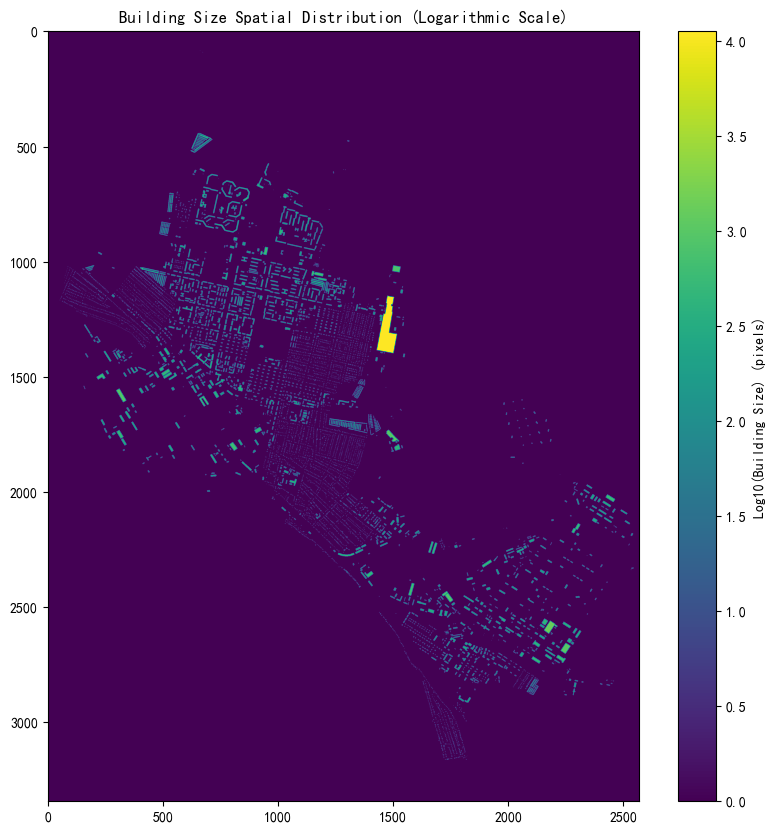

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure
import seaborn as sns
import logging
from tqdm import tqdm
from scipy import stats

# Basic configurations
Image.MAX_IMAGE_PIXELS = None  # Remove image size limit
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')

# Set font for plotting
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    

def pixel_to_area(pixels, resolution=3.0):
    """
    Convert pixel count to actual area (square meters)
    
    Args:
        pixels: number of pixels
        resolution: resolution (meters/pixel)
    """
    return pixels * (resolution ** 2)

def analyze_building_sizes(building_mask, resolution=3.0):
    """
    Analyze building size distribution, handling outliers
    
    Args:
        building_mask: binary building mask image
        resolution: image resolution (meters/pixel)
    """
    # Connected component analysis
    print("Performing connected component analysis...")
    building_labels = measure.label(building_mask)
    num_buildings = building_labels.max()
    print(f"Detected building count: {num_buildings}")
    
    # Collect building sizes
    print("\nCalculating building sizes...")
    sizes = []
    for building_id in tqdm(range(1, num_buildings + 1), desc="Processing buildings"):
        building_mask = building_labels == building_id
        size = np.sum(building_mask)
        sizes.append(size)
    
    sizes = np.array(sizes)
    areas = np.array([pixel_to_area(s, resolution) for s in sizes])
    
    # Calculate outlier boundaries
    Q1 = np.percentile(sizes, 25)
    Q3 = np.percentile(sizes, 75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    
    # Convert pixel thresholds to areas
    upper_bound_area = pixel_to_area(upper_bound, resolution)
    
    # Print detailed threshold information
    print("\nOutlier Threshold Details:")
    print(f"Q1 (25th percentile): {Q1:.1f} pixels ({pixel_to_area(Q1, resolution):.1f} m²)")
    print(f"Q3 (75th percentile): {Q3:.1f} pixels ({pixel_to_area(Q3, resolution):.1f} m²)")
    print(f"IQR: {IQR:.1f} pixels ({pixel_to_area(IQR, resolution):.1f} m²)")
    print(f"Outlier threshold (Q3 + 1.5*IQR): {upper_bound:.1f} pixels ({upper_bound_area:.1f} m²)")
    
    # Separate normal values and outliers
    normal_sizes = sizes[sizes <= upper_bound]
    outlier_sizes = sizes[sizes > upper_bound]
    normal_areas = areas[sizes <= upper_bound]
    outlier_areas = areas[sizes > upper_bound]
    
    # Print outlier statistics
    if len(outlier_sizes) > 0:
        print(f"\nOutlier Statistics:")
        print(f"Smallest outlier: {outlier_sizes.min():.1f} pixels ({outlier_areas.min():.1f} m²)")
        print(f"Largest outlier: {outlier_sizes.max():.1f} pixels ({outlier_areas.max():.1f} m²)")
        print(f"Mean outlier size: {outlier_sizes.mean():.1f} pixels ({outlier_areas.mean():.1f} m²)")
    
    # Create outlier mask
    print("\nProcessing outlier buildings...")
    outlier_buildings = np.zeros_like(building_mask, dtype=bool)
    normal_buildings = np.zeros_like(building_mask, dtype=bool)
    
    for building_id in tqdm(range(1, num_buildings + 1), desc="Identifying outliers"):
        current_mask = building_labels == building_id
        size = np.sum(current_mask)
        if size > upper_bound:
            outlier_buildings |= current_mask
        else:
            normal_buildings |= current_mask
    
    print("\nStatistics:")
    print(f"Total number of buildings: {len(sizes)}")
    print(f"Number of normal buildings: {len(normal_sizes)}")
    print(f"Number of outliers: {len(outlier_sizes)}")
    
    # Create multi-subplot visualization
    plt.figure(figsize=(15, 15))
    
    # 1. Original distribution (with outlier marking)
    plt.subplot(3, 1, 1)
    sns.histplot(data=areas, bins=50, color='blue', alpha=0.5, label='All Buildings')
    plt.axvline(pixel_to_area(upper_bound, resolution), color='red', linestyle='--', 
                label='Outlier Threshold')
    plt.title('Complete Building Size Distribution')
    plt.xlabel('Area (m²)')
    plt.ylabel('Count')
    plt.legend()
    
    # 2. Normal value distribution (outliers removed)
    plt.subplot(3, 1, 2)
    sns.histplot(data=normal_areas, bins=50, color='green', alpha=0.5)
    plt.title('Building Size Distribution (Outliers Removed)')
    plt.xlabel('Area (m²)')
    plt.ylabel('Count')
    
    # 3. Logarithmic scale distribution
    plt.subplot(3, 1, 3)
    sns.histplot(data=np.log10(areas), bins=50, color='purple', alpha=0.5)
    plt.title('Building Size Distribution (Logarithmic Scale)')
    plt.xlabel('Log10(Area) (m²)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Box plot visualization
    plt.figure(figsize=(10, 6))
    plt.boxplot(areas, vert=False, whis=1.5)
    plt.title('Building Size Box Plot')
    plt.xlabel('Area (m²)')
    plt.show()
    
    # Statistical summary
    print("\nNormal Value Statistics (After Removing Outliers):")
    print(f"Minimum area: {normal_areas.min():.1f} m²")
    print(f"Maximum area: {normal_areas.max():.1f} m²")
    print(f"Mean area: {normal_areas.mean():.1f} m²")
    print(f"Median area: {np.median(normal_areas):.1f} m²")
    
    # Display outlier building map
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(normal_buildings, cmap='viridis')
    plt.title('Normal Buildings')
    plt.colorbar()
    
    plt.subplot(122)
    plt.imshow(outlier_buildings, cmap='viridis')
    plt.title('Outlier Buildings')
    plt.colorbar()
    plt.show()
    
    # Spatial distribution plot (using logarithmic scale)
    plt.figure(figsize=(10, 10))
    building_sizes = np.zeros_like(building_labels, dtype=float)
    for building_id in tqdm(range(1, num_buildings + 1), desc="Generating spatial distribution"):
        building_mask = building_labels == building_id
        size = np.sum(building_mask)
        building_sizes[building_mask] = np.log10(size) if size > 0 else 0
    
    plt.imshow(building_sizes, cmap='viridis')
    plt.colorbar(label='Log10(Building Size) (pixels)')
    plt.title('Building Size Spatial Distribution (Logarithmic Scale)')
    plt.show()
    
    return sizes, normal_sizes, outlier_sizes, outlier_buildings, normal_buildings

def main():
    # Replace with your mask file path
    image_path = '../images/20210709_073742_79_2431_3B_Visual_clip.tif'
    building_mask_path = "../buildingmasks/mask_Rubizhne.tif"
    
    print("Starting data loading...")
    try:
        # Load and resize mask properly
        original_image = Image.open(image_path)
        width, height = original_image.size
        
        # Load mask as PIL Image first
        mask_image = Image.open(building_mask_path)
        # Resize while it's still a PIL Image
        mask_image = mask_image.resize((width, height), Image.NEAREST)
        # Convert to numpy array after resizing
        mask = np.array(mask_image)
        
        if mask.ndim > 2:
            print("Detected multi-channel image, converting to single channel...")
            mask = mask[:,:,0]  # If multi-channel, take the first channel
        
        mask = mask > 0  # Binarize
        print("Data loading complete, starting analysis...")
        
        # Analyze building size distribution
        sizes, normal_sizes, outlier_sizes, outlier_buildings, normal_buildings = analyze_building_sizes(mask, resolution=3.0)
        
    except Exception as e:
        print(f"Error occurred during analysis: {e}")

if __name__ == "__main__":
    main()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure

def show_fixed_threshold(image_path, mask_path, threshold=1000):
    """
    显示大于指定阈值的建筑物分布
    Args:
        image_path: 原始图像路径
        mask_path: 建筑物掩码路径
        threshold: 建筑物面积阈值（显示大于此阈值的建筑）
    """
    # 加载原始图像和获取尺寸
    original_image = Image.open(image_path)
    width, height = original_image.size
    image = np.array(original_image)
    
    # 加载掩码并调整大小
    mask_image = Image.open(mask_path)
    mask_image = mask_image.resize((width, height), Image.NEAREST)
    mask = np.array(mask_image)
    
    # 如果掩码是多通道的，转换为单通道
    if mask.ndim > 2:
        mask = mask[:,:,0]
    
    # 创建图形
    plt.figure(figsize=(20, 6))
    
    # 1. 显示原始图像
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # 2. 显示所有建筑
    plt.subplot(132)
    plt.imshow(image)
    plt.imshow(mask > 0, alpha=0.3, cmap='cool')
    plt.title('All Buildings')
    plt.axis('off')
    
    # 3. 处理并显示大型建筑
    plt.subplot(133)
    building_labels = measure.label(mask)
    large_buildings = np.zeros_like(mask, dtype=bool)
    
    # 统计信息
    large_count = 0
    total_large_area = 0
    all_sizes = []
    
    for building_id in range(1, building_labels.max() + 1):
        current_mask = building_labels == building_id
        building_size = np.sum(current_mask)
        all_sizes.append(building_size)
        
        if building_size >= threshold:  # 大于等于阈值
            large_buildings |= current_mask
            large_count += 1
            total_large_area += building_size
    
    # 只显示大型建筑的掩码，不显示背景图像
    plt.imshow(large_buildings, cmap='hot')
    plt.title(f'Large Buildings (>={threshold} pixels, Count: {large_count})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\nBuilding Statistics (Threshold: {threshold} pixels):")
    print(f"Number of Large Buildings (>={threshold} pixels): {large_count}")
    print(f"Total Number of Buildings: {len(all_sizes)}")
    print(f"Proportion of Large Buildings: {large_count/len(all_sizes)*100:.1f}%")
    if large_count > 0:
        print(f"Average Area of Large Buildings: {total_large_area/large_count:.2f} pixels")
    print(f"Average Area of All Buildings: {np.mean(all_sizes):.2f} pixels")
    print(f"Minimum Building Area: {min(all_sizes)} pixels")
    print(f"Maximum Building Area: {max(all_sizes)} pixels")
    
    # 显示面积分布直方图，只显示小于阈值的建筑
    plt.figure(figsize=(10, 4))
    sizes_under_threshold = [size for size in all_sizes if size < threshold]
    plt.hist(sizes_under_threshold, bins=50, edgecolor='black')
    plt.axvline(x=threshold, color='r', linestyle='--', label='Large Building Threshold')
    plt.xlabel('Building Area (pixels)')
    plt.ylabel('Count')
    plt.title(f'Building Size Distribution (<{threshold} pixels, Count: {len(sizes_under_threshold)})')
    plt.legend()
    plt.show()

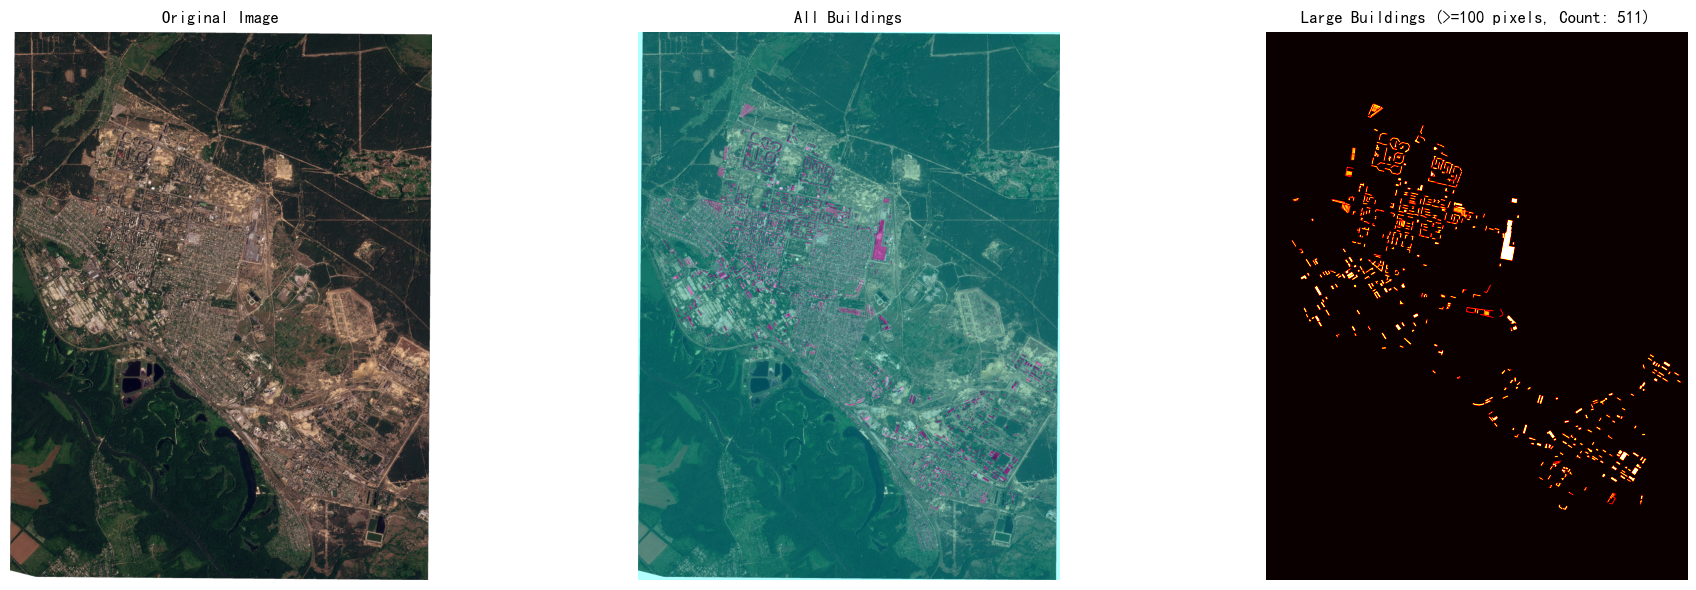


Building Statistics (Threshold: 100 pixels):
Number of Large Buildings (>=100 pixels): 511
Total Number of Buildings: 6603
Proportion of Large Buildings: 7.7%
Average Area of Large Buildings: 224.11 pixels
Average Area of All Buildings: 32.68 pixels
Minimum Building Area: 1 pixels
Maximum Building Area: 11271 pixels


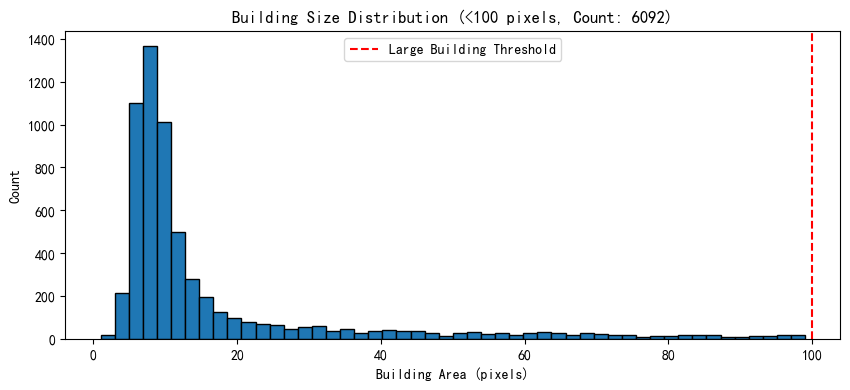

In [12]:
# 使用示例
# 可以尝试不同的阈值\
thresholds = [100]
for threshold in thresholds:
    show_fixed_threshold('../images/20210709_073742_79_2431_3B_Visual_clip.tif', 
                        '../buildingmasks/mask_Rubizhne.tif',
                        threshold=threshold)

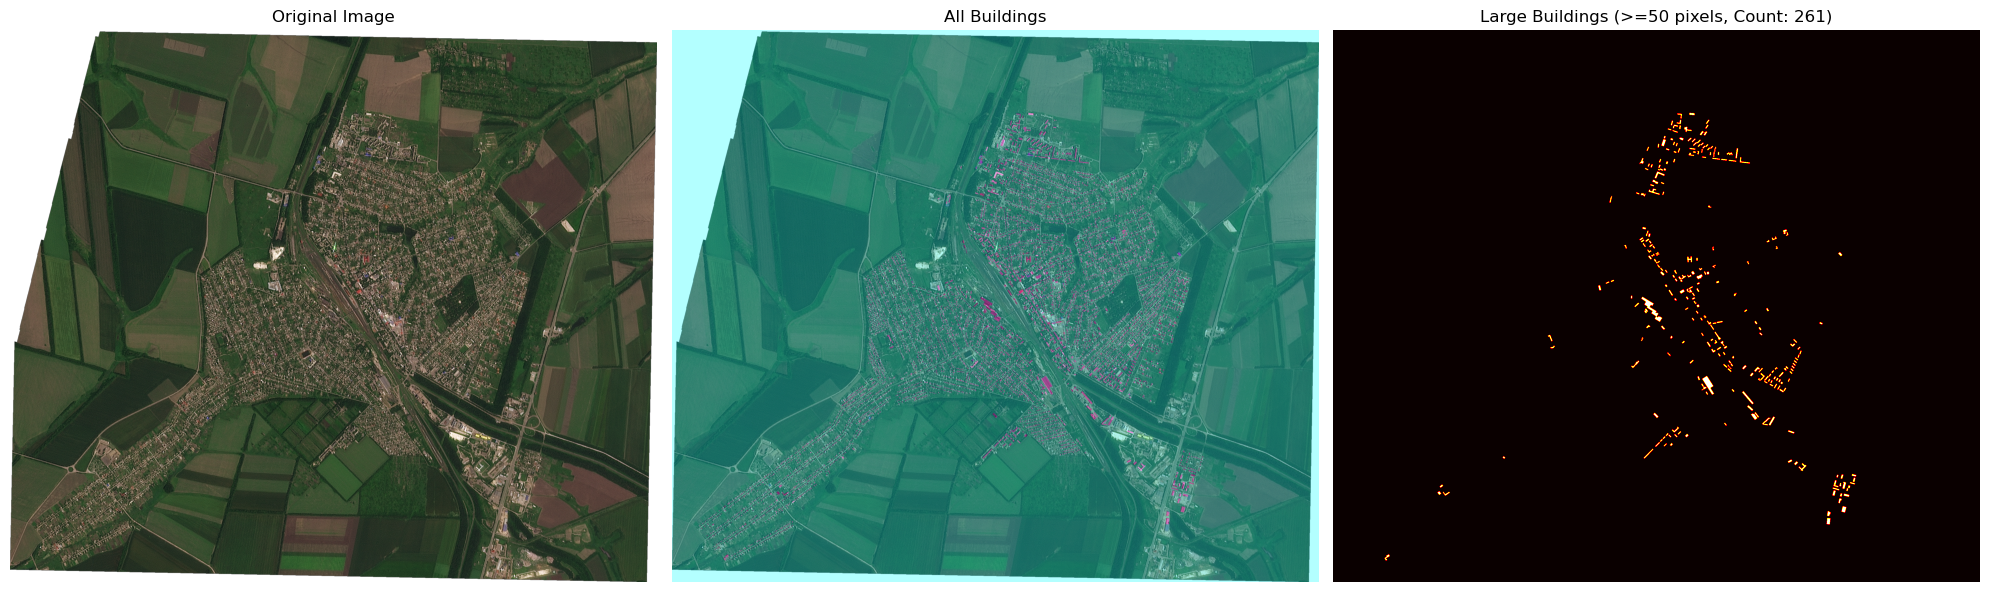


Building Statistics (Threshold: 50 pixels):
Number of Large Buildings (>=50 pixels): 261
Total Number of Buildings: 6441
Proportion of Large Buildings: 4.1%
Average Area of Large Buildings: 106.66 pixels
Average Area of All Buildings: 15.87 pixels
Minimum Building Area: 1 pixels
Maximum Building Area: 1756 pixels


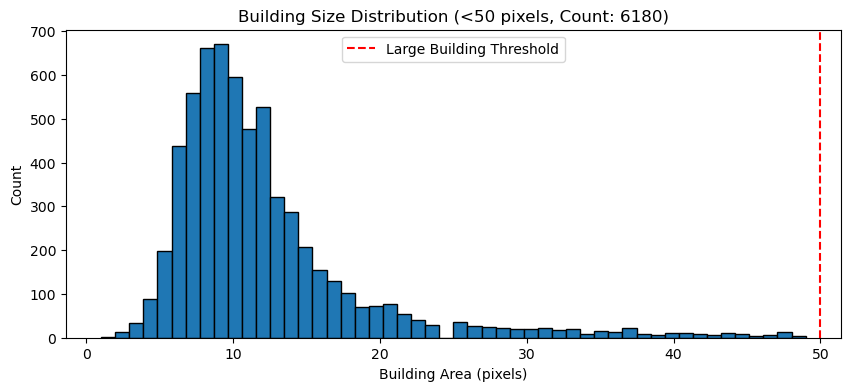

In [10]:
# 使用示例
# 可以尝试不同的阈值\
thresholds = [50]
for threshold in thresholds:
    show_fixed_threshold('../images/Volnovakha_20210622_20220512_pre.tif', 
                        '../buildingmasks/mask_Volnovakha.tif',
                        threshold=threshold)

**下面是mask相关

Unique values in the mask: [0 1]


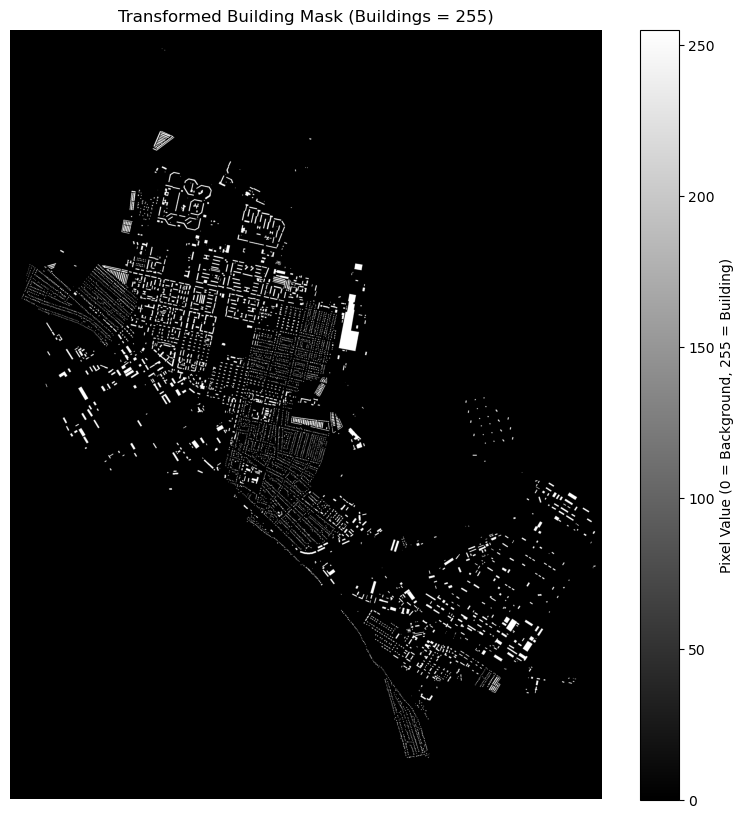

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_building_mask(mask_path):
    """
    Visualize the building mask where building pixels have a value of 255.

    Args:
        mask_path (str): Path to the mask file.
    """
    try:
        # Load the mask
        mask = np.array(Image.open(mask_path))

        # Print unique values in the mask
        unique_values = np.unique(mask)
        print(f"Unique values in the mask: {unique_values}")

        # Check if the mask is grayscale or multi-channel
        if mask.ndim > 2:
            print("Detected multi-channel image, converting to single channel...")
            mask = mask[:, :, 0]  # Use the first channel

        # Transform building mask values from 1 to 255
        transformed_mask = np.where(mask == 1, 255, 0).astype(np.uint8)

        # Visualize the transformed mask
        plt.figure(figsize=(10, 10))
        plt.imshow(transformed_mask, cmap="gray")
        plt.title("Transformed Building Mask (Buildings = 255)")
        plt.axis("off")
        plt.colorbar(label="Pixel Value (0 = Background, 255 = Building)")
        plt.show()

    except Exception as e:
        print(f"Error while visualizing building mask: {e}")

# Example usage
# Replace with your actual mask file path
mask_path = "../buildingmasks/mask_Rubizhne_resized.tif"
visualize_building_mask(mask_path)


In [12]:
from PIL import Image
import numpy as np

# 读取图像
image = Image.open('../buildingmasks/mask_Rubizhne_resized.tif')
# 获取分辨率
width, height = image.size
print(f'mask分辨率为: {width} x {height} 像素')
# 读取图像
image = Image.open('../images/Pre/20210709_073742_79_2431_3B_Visual_clip.tif')

# 获取分辨率
width, height = image.size
print(f'图像分辨率为: {width} x {height} 像素')

mask分辨率为: 2568 x 3344 像素
图像分辨率为: 2568 x 3344 像素


In [4]:
import numpy as np

def resize_mask(input_path, output_path, target_size):
    """
    Resize a mask image to target size and save it
    
    Args:
        input_path: Path to input mask file
        output_path: Path to save resized mask
        target_size: Tuple of (width, height)
    """
    # Load the mask
    mask_image = Image.open(input_path)
    
    # Resize using nearest neighbor interpolation to preserve mask values
    resized_mask = mask_image.resize(target_size, Image.NEAREST)
    
    # Convert to numpy array to verify
    mask_array = np.array(resized_mask)
    
    # Print shape information
    print(f"Original size: {mask_image.size}")
    print(f"New size: {resized_mask.size}")
    print(f"Array shape: {mask_array.shape}")
    
    # Save the resized mask
    resized_mask.save(output_path)
    print(f"\nResized mask saved to: {output_path}")

# Specify paths and target size
input_mask_path = "../buildingmasks/mask_Rubizhne.tif"
output_mask_path = "../buildingmasks/mask_Rubizhne_resized.tif"
target_size = (2568, 3344)  # (width, height)

# Execute the resize
resize_mask(input_mask_path, output_mask_path, target_size)

Original size: (10272, 13376)
New size: (2568, 3344)
Array shape: (3344, 2568)

Resized mask saved to: ../buildingmasks/mask_Rubizhne_resized.tif


In [5]:
from PIL import Image
import numpy as np
input_mask_path = "../buildingmasks/mask_Rubizhne_damagelevel_43to2.tif"
mask = np.array(Image.open(input_mask_path))

print(np.unique(mask))

[0. 1. 2. 3. 4.]


In [4]:
from PIL import Image
import numpy as np

def check_image_channels(image_path):
    """
    检查图像的通道数和其他基本信息
    
    Args:
        image_path (str): 图像文件路径
    """
    # 打开图像
    img = Image.open(image_path)
    
    # 转换为numpy数组
    img_array = np.array(img)
    
    # 打印基本信息
    print(f"图像模式 (mode): {img.mode}")
    print(f"图像大小 (size): {img.size}")
    print(f"数组形状 (shape): {img_array.shape}")
    print(f"数据类型 (dtype): {img_array.dtype}")
    
    # 如果是多通道图像，打印每个通道的值范围
    if len(img_array.shape) > 2:
        for i in range(img_array.shape[2]):
            channel = img_array[:,:,i]
            print(f"通道 {i} 的值范围: [{np.min(channel)}, {np.max(channel)}]")
    
    return img_array

# 检查pre-image
pre_img_path = '../images/Pre/Image512/Rubizhne_20210709_20220707_pre.tif'
print("Pre-image信息:")
pre_array = check_image_channels(pre_img_path)

# 检查post-image
post_img_path = '../images/Post/Image512/Rubizhne_20210709_20220707_post.tif'
print("\nPost-image信息:")
post_array = check_image_channels(post_img_path)

# 检查mask
mask_path = "../buildingmasks/mask_Rubizhne_damagelevel_43to2.tif"
print("\nMask信息:")
mask_array = check_image_channels(mask_path)

Pre-image信息:
图像模式 (mode): RGBA
图像大小 (size): (2568, 3344)
数组形状 (shape): (3344, 2568, 4)
数据类型 (dtype): uint8
通道 0 的值范围: [0, 255]
通道 1 的值范围: [0, 255]
通道 2 的值范围: [0, 255]
通道 3 的值范围: [0, 255]

Post-image信息:
图像模式 (mode): RGBA
图像大小 (size): (2568, 3344)
数组形状 (shape): (3344, 2568, 4)
数据类型 (dtype): uint8
通道 0 的值范围: [0, 255]
通道 1 的值范围: [0, 255]
通道 2 的值范围: [0, 255]
通道 3 的值范围: [0, 255]

Mask信息:
图像模式 (mode): F
图像大小 (size): (2568, 3344)
数组形状 (shape): (3344, 2568)
数据类型 (dtype): float32


In [12]:
from PIL import Image
import numpy as np

def check_image_channels(image_path):
    """
    检查图像的通道数和其他基本信息
    
    Args:
        image_path (str): 图像文件路径
    """
    # 打开图像
    img = Image.open(image_path)
    
    # 转换为numpy数组
    img_array = np.array(img)
    
    # 打印基本信息
    print(f"图像模式 (mode): {img.mode}")
    print(f"图像大小 (size): {img.size}")
    print(f"数组形状 (shape): {img_array.shape}")
    print(f"数据类型 (dtype): {img_array.dtype}")
    
    # 如果是多通道图像，打印每个通道的值范围
    if len(img_array.shape) > 2:
        for i in range(img_array.shape[2]):
            channel = img_array[:,:,i]
            print(f"通道 {i} 的值范围: [{np.min(channel)}, {np.max(channel)}]")
    
    return img_array

# 检查pre-image
pre_img_path = '../images/Volnovakha_20210622_20220512_pre.tif'
print("Pre-image信息:")
pre_array = check_image_channels(pre_img_path)

# 检查post-image
post_img_path = '../images/Volnovakha_20210622_20220512_post.tif'
print("\nPost-image信息:")
post_array = check_image_channels(post_img_path)

# 检查mask
mask_path = "../buildingmasks/mask_Volnovakha_damagelevel_43to2.tif"
print("\nMask信息:")
mask_array = check_image_channels(mask_path)
# 打开图像
img = Image.open(mask_path)

# 转换为numpy数组
img_array = np.array(img)
print(np.unique(img_array))
print(np.shape(img_array))
mask_path = "../buildingmasks/mask_Volnovakha.tif"
img = Image.open(mask_path)

# 转换为numpy数组
img_array = np.array(img)
print(np.unique(img_array))
print(np.shape(img_array))

Pre-image信息:
图像模式 (mode): RGBA
图像大小 (size): (2569, 2192)
数组形状 (shape): (2192, 2569, 4)
数据类型 (dtype): uint8
通道 0 的值范围: [0, 255]
通道 1 的值范围: [0, 255]
通道 2 的值范围: [0, 255]
通道 3 的值范围: [0, 255]

Post-image信息:
图像模式 (mode): RGBA
图像大小 (size): (2569, 2192)
数组形状 (shape): (2192, 2569, 4)
数据类型 (dtype): uint8
通道 0 的值范围: [0, 255]
通道 1 的值范围: [0, 255]
通道 2 的值范围: [0, 255]
通道 3 的值范围: [0, 255]

Mask信息:
图像模式 (mode): F
图像大小 (size): (2569, 2192)
数组形状 (shape): (2192, 2569)
数据类型 (dtype): float32
[0. 1. 2. 3. 4.]
(2192, 2569)
[0. 1.]
(2192, 2569)
